# SDA Revenue Analysis of Megaline Prepaid Plans: Surf vs. Ultimate

Megaline, a leading telecom operator, offers its customers two prepaid plans: Surf and Ultimate. The company seeks to optimize its advertising budget by identifying which plan generates more revenue. To achieve this,the project will conduct a detailed analysis of customer behavior using data from a sample of 500 clients in 2018.

***This project involves:***

1. Preparing and cleaning the data to ensure accurate analysis.
2. Analyzing usage patterns, including calls, texts, and internet consumption, for each plan.
3. Calculating monthly revenue per user, taking into account plan limits and additional charges.
4. Testing hypotheses to identify statistically significant revenue differences between the plans and among various customer demographics.

By the end of this project, it will provide actionable insights to help Megaline allocate its advertising resources effectively and enhance its revenue strategy.

***The 5 data frames that compose this project are:***

**users_df**
- includes data about: user ids, user name and age, user location, and type of plan

**calls_df**
- incudes data about amount and duration of user calls for specific dates

**messages_df**
- contains data on amount of user messages sent for specific dates

**internet_df**
- amount of internet used (mb) by user for specific dates

**plans_df**
- information on the two different plans for example what is included in the monthly plan and the orverage costs

## Initialization

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
import math as mt
import seaborn as sns

## Load data

In [2]:
users_df = pd.read_csv('/datasets/megaline_users.csv' )
calls_df = pd.read_csv('/datasets/megaline_calls.csv')
messages_df = pd.read_csv('/datasets/megaline_messages.csv')
internet_df = pd.read_csv('/datasets/megaline_internet.csv')
plans_df = pd.read_csv('/datasets/megaline_plans.csv')

In [3]:
# Merge unique user IDs from all data frames into one set
combined_user_ids = set(users_df['user_id'].unique()) | set(calls_df['user_id'].unique()) | set(messages_df['user_id'].unique()) | set(internet_df['user_id'].unique())

# Calculate the total number of unique user IDs
total_unique_user_ids = len(combined_user_ids)

print(total_unique_user_ids)

500


***Take Away:***

- There are different amounts of unique user_ids in all the data frames. However, there are in total 500 unique user_id's

## Prepare the data

## Plans

In [4]:
plans_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes


In [5]:
plans_df.head()

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


### plans_df summary and changes:
- plan data with no missing information

## Users

In [6]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [7]:
display(users_df.head())

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN


### Fix Data

In [ ]:
users_df['user_id'].value_counts() # checking for duplicated user ids
users_df.duplicated().sum() # checking for full line duplicatation
users_df.duplicated(subset=['first_name','last_name']).sum() 
# checking for user name duplication to make sure each user is only in the system once

0

### Enrich Data

In [9]:
#Change Dtype to dt instead of object for 'reg_date' and 'churn_date'
users_df['reg_date'] = pd.to_datetime(users_df['reg_date'])
users_df['churn_date'] = pd.to_datetime(users_df['churn_date'])
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   first_name  500 non-null    object        
 2   last_name   500 non-null    object        
 3   age         500 non-null    int64         
 4   city        500 non-null    object        
 5   reg_date    500 non-null    datetime64[ns]
 6   plan        500 non-null    object        
 7   churn_date  34 non-null     datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


### users_df summary and changes:
- churn_date — the value is missing means the calling plan was being used when this database was extracted
- only 34 customers have left this calling plan
- no duplicate user ids
- no complete duplicated rows
- no duplicated first and last names / mean no users with mutiple user ids
- changed Dtype to datetime instead of object for 'reg_date' and 'churn_date'

## Calls

In [10]:
calls_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


In [11]:
display(calls_df.head())

,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22


### Fix data

In [12]:
calls_df.duplicated().sum() # checking fulling duplicated lines
calls_df['id'].duplicated().sum() # checking to see if the id is duplicated

0

### Enrich data

In [13]:
# changing 'call_date' to datetime instead of object
calls_df['call_date'] = pd.to_datetime(calls_df['call_date'])
calls_df.info()

#calls_df['call_date_month'] = calls_df['call_date'].dt.month_name()
calls_df['call_month_num'] = calls_df['call_date'].dt.month
# adding month name and number to make it easier to aggregate by month

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         137735 non-null  object        
 1   user_id    137735 non-null  int64         
 2   call_date  137735 non-null  datetime64[ns]
 3   duration   137735 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 4.2+ MB


### calls_df summary and changes:

- no null values in any columns
- no fully duplicated lines
- no duplicated calls in the data
- changed Dtype of 'call_date' to datetime instead of object
- added a month number data column to make it easier to veiw the calls by month


## Messages

In [14]:
messages_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [15]:
display(messages_df.head())

,id,user_id,message_date
0,1000_125,1000,2018-12-27
1,1000_160,1000,2018-12-31
2,1000_223,1000,2018-12-31
3,1000_251,1000,2018-12-27
4,1000_255,1000,2018-12-26


### Fix data

In [16]:
messages_df.duplicated().sum() # checking for fully duplicated lines
messages_df['id'].duplicated().sum() # checking for duplicated ids

0

### Enrich data

In [17]:
# changing 'call_date' to datetime instead of object
messages_df['message_date'] = pd.to_datetime(messages_df['message_date'] )

#messages_df['message_month'] = messages_df['message_date'].dt.month_name() 
messages_df['message_month_num'] = messages_df['message_date'].dt.month
# adding month name to make it easier to aggregate by month

### messages_df summary and changes:
- no missing data
- changed dtype to datetime instead of object for message_date
- no fully duplicated lines
- no duplicated call 'id's
- added a month number column to make it easier to aggregate by month

## Internet

In [18]:
internet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


In [19]:
display(internet_df.head())

,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86
1,1000_204,1000,2018-12-31,0.00
2,1000_379,1000,2018-12-28,660.40
3,1000_413,1000,2018-12-26,270.99
4,1000_442,1000,2018-12-27,880.22


### Fix data

In [20]:
internet_df.duplicated().sum() # checking for fully duplicated lines
internet_df['id'].duplicated().sum() # checking for duplicated call 'id's


0

### Enrich data

In [21]:
# changing 'call_date' to datetime instead of object
internet_df['session_date'] = pd.to_datetime(internet_df['session_date'])

#internet_df['internet_month'] = internet_df['session_date'].dt.month_name() 
internet_df['internet_month_num'] = internet_df['session_date'].dt.month
# adding month name to make it easier to aggregate by month

### internet_df summary and changes:
- no missing data
- no fully duplicated lines
- no duplicated call 'id's
- changed Dtype of 'session_date' to datetime instead of object
- added a month number column to make it easier to aggregate by month

<div class="alert alert-info" style="border-left: 7px solid blue">
<b>Looking into the zeros below.
</b>
</div>

In [22]:
display(calls_df.describe()) 

zero_calls_dur = calls_df[calls_df['duration']==0]
display(calls_df.info())
display(zero_calls_dur.info())

percent_zero_calls = 26834/137735*100
print(percent_zero_calls)
display(zero_calls_dur['user_id'].unique())

,user_id,duration,call_month_num
count,137735.000000,137735.000000,137735.000000
mean,1247.658046,6.745927,9.320797
std,139.416268,5.839241,2.412550
min,1000.000000,0.000000,1.000000
25%,1128.000000,1.290000,8.000000
50%,1247.000000,5.980000,10.000000
75%,1365.000000,10.690000,11.000000
max,1499.000000,37.600000,12.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   id              137735 non-null  object        
 1   user_id         137735 non-null  int64         
 2   call_date       137735 non-null  datetime64[ns]
 3   duration        137735 non-null  float64       
 4   call_month_num  137735 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 5.3+ MB


None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26834 entries, 19 to 137725
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id              26834 non-null  object        
 1   user_id         26834 non-null  int64         
 2   call_date       26834 non-null  datetime64[ns]
 3   duration        26834 non-null  float64       
 4   call_month_num  26834 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 1.2+ MB


None

19.482339274694162


array([1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011,
       1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022,
       1023, 1024, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1035,
       1036, 1037, 1038, 1039, 1040, 1041, 1042, 1043, 1044, 1045, 1046,
       1047, 1048, 1049, 1050, 1051, 1052, 1053, 1054, 1055, 1056, 1057,
       1058, 1059, 1060, 1061, 1062, 1063, 1064, 1065, 1066, 1067, 1068,
       1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076, 1077, 1078, 1079,
       1081, 1082, 1083, 1084, 1085, 1086, 1087, 1088, 1090, 1091, 1092,
       1093, 1094, 1095, 1096, 1097, 1098, 1099, 1100, 1101, 1102, 1103,
       1104, 1105, 1106, 1107, 1109, 1110, 1111, 1112, 1113, 1114, 1115,
       1116, 1117, 1118, 1119, 1120, 1122, 1123, 1124, 1125, 1126, 1127,
       1128, 1130, 1132, 1133, 1134, 1135, 1136, 1138, 1139, 1140, 1141,
       1142, 1144, 1145, 1146, 1147, 1148, 1149, 1150, 1151, 1152, 1153,
       1154, 1155, 1156, 1157, 1158, 1159, 1160, 11

***Take Aways:***
- 19% of the call duration data is zero. This could skew the data and analysis but it can't be ruled out that this is accurate data that users didn't make calls during some months considering the amount of users that made zero calls.

In [23]:
display(internet_df.describe())

zero_internet = internet_df[internet_df['mb_used']==0]
display(internet_df.info())
display(zero_internet.info())

percent_zero_internet = 13747/104825*100
print(percent_zero_internet)
display(zero_internet['user_id'].unique())

,user_id,mb_used,internet_month_num
count,104825.000000,104825.000000,104825.000000
mean,1242.496361,366.713701,9.342552
std,142.053913,277.170542,2.400404
min,1000.000000,0.000000,1.000000
25%,1122.000000,136.080000,8.000000
50%,1236.000000,343.980000,10.000000
75%,1367.000000,554.610000,11.000000
max,1499.000000,1693.470000,12.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   id                  104825 non-null  object        
 1   user_id             104825 non-null  int64         
 2   session_date        104825 non-null  datetime64[ns]
 3   mb_used             104825 non-null  float64       
 4   internet_month_num  104825 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 4.0+ MB


None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13747 entries, 1 to 104823
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   id                  13747 non-null  object        
 1   user_id             13747 non-null  int64         
 2   session_date        13747 non-null  datetime64[ns]
 3   mb_used             13747 non-null  float64       
 4   internet_month_num  13747 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 644.4+ KB


None

13.11423801574052


array([1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010,
       1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021,
       1022, 1023, 1024, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033,
       1035, 1036, 1037, 1038, 1039, 1040, 1041, 1042, 1043, 1044, 1045,
       1046, 1047, 1048, 1049, 1050, 1051, 1052, 1053, 1054, 1055, 1056,
       1057, 1058, 1059, 1060, 1061, 1062, 1063, 1064, 1065, 1066, 1067,
       1068, 1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076, 1077, 1078,
       1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087, 1088, 1089,
       1090, 1091, 1092, 1093, 1094, 1095, 1096, 1097, 1098, 1099, 1100,
       1101, 1102, 1103, 1104, 1105, 1106, 1107, 1109, 1110, 1111, 1112,
       1113, 1114, 1115, 1116, 1117, 1118, 1120, 1121, 1122, 1123, 1124,
       1125, 1126, 1127, 1128, 1130, 1131, 1132, 1133, 1134, 1136, 1137,
       1138, 1139, 1140, 1141, 1142, 1144, 1145, 1146, 1147, 1148, 1149,
       1150, 1151, 1152, 1153, 1154, 1155, 1156, 11

***Take Away:***
- 13% of the internet data is zero. This could skew the data and analysis but it can't be ruled out that this is accurate data that users didn't use internet during some months considering the amount of users that made zero calls.

## Study plan conditions

In [24]:
display(plans_df)

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


## Aggregate data per user

In [25]:
# Calculate the number of calls made by each user per month. Save the result.
calls_per_month = calls_df.groupby(['user_id', 'call_month_num',]).size().reset_index(name='num_calls')
calls_per_month.rename(columns={'call_month_num': 'month'}, inplace=True)
display(calls_per_month.head())
calls_per_month.info()

,user_id,month,num_calls
0,1000,12,16
1,1001,8,27
2,1001,9,49
3,1001,10,65
4,1001,11,64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2258 entries, 0 to 2257
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   user_id    2258 non-null   int64
 1   month      2258 non-null   int64
 2   num_calls  2258 non-null   int64
dtypes: int64(3)
memory usage: 53.0 KB


In [26]:
# Calculate the amount of minutes spent by each user per month. Save the result.
# rounds up each call to nearest minute
calls_df['rounded_call_duration'] = calls_df['duration'].apply(lambda x: mt.ceil(x))
display(calls_df.head())

min_per_month = calls_df.groupby(['user_id', 'call_month_num']).agg({'duration':'sum','rounded_call_duration':'sum'})#.reset_index(name='min_calls')
min_per_month = min_per_month.reset_index()
min_per_month.rename(columns={'call_month_num': 'month'}, inplace=True)
display(min_per_month.head())
min_per_month.info()

,id,user_id,call_date,duration,call_month_num,rounded_call_duration
0,1000_93,1000,2018-12-27,8.52,12,9
1,1000_145,1000,2018-12-27,13.66,12,14
2,1000_247,1000,2018-12-27,14.48,12,15
3,1000_309,1000,2018-12-28,5.76,12,6
4,1000_380,1000,2018-12-30,4.22,12,5


,user_id,month,duration,rounded_call_duration
0,1000,12,116.83,124
1,1001,8,171.14,182
2,1001,9,297.69,315
3,1001,10,374.11,393
4,1001,11,404.59,426


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2258 entries, 0 to 2257
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                2258 non-null   int64  
 1   month                  2258 non-null   int64  
 2   duration               2258 non-null   float64
 3   rounded_call_duration  2258 non-null   int64  
dtypes: float64(1), int64(3)
memory usage: 70.7 KB


In [27]:
# Calculate the number of messages sent by each user per month. Save the result.
message_per_month = messages_df.groupby(['user_id', 'message_month_num']).size().reset_index(name='message_count')
message_per_month.rename(columns={'message_month_num':'month'}, inplace=True)

display(message_per_month.head())
message_per_month.info()

,user_id,month,message_count
0,1000,12,11
1,1001,8,30
2,1001,9,44
3,1001,10,53
4,1001,11,36


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1806 entries, 0 to 1805
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   user_id        1806 non-null   int64
 1   month          1806 non-null   int64
 2   message_count  1806 non-null   int64
dtypes: int64(3)
memory usage: 42.5 KB


In [28]:
# Calculate the volume of internet traffic used by each user per month. Save the result.
internet_per_month = internet_df.groupby(['user_id', 'internet_month_num'])['mb_used'].sum().reset_index(name='mb_per_month')
# rounds end of month numbers up
internet_per_month['mb_per_month'] = internet_per_month['mb_per_month'].apply(lambda x: mt.ceil(x))

display(internet_per_month.head())

#the total for the month is rounded up. 
#If someone uses 1025 megabytes this month, they will be charged for 2 gigabytes.
internet_per_month['gb_month'] = internet_per_month['mb_per_month'].apply(lambda x: mt.ceil(x / 1024))

internet_per_month.rename(columns={'internet_month_num': 'month'}, inplace=True)
display(internet_per_month.head())
internet_per_month.info()

,user_id,internet_month_num,mb_per_month
0,1000,12,1902
1,1001,8,6920
2,1001,9,13315
3,1001,10,22331
4,1001,11,18505


,user_id,month,mb_per_month,gb_month
0,1000,12,1902,2
1,1001,8,6920,7
2,1001,9,13315,14
3,1001,10,22331,22
4,1001,11,18505,19


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2277 entries, 0 to 2276
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   user_id       2277 non-null   int64
 1   month         2277 non-null   int64
 2   mb_per_month  2277 non-null   int64
 3   gb_month      2277 non-null   int64
dtypes: int64(4)
memory usage: 71.3 KB


In [29]:
# Merge the data for calls, minutes, messages, internet based on user_id and month
display(users_df.info()) #'plan' no null values

data_per_month = users_df.merge(calls_per_month, on='user_id', how='outer', suffixes=('_users', '_calls'))
display(data_per_month.info()) #'plan' no null values

data_per_month = data_per_month.merge(min_per_month, on=['user_id', 'month'], how='outer', suffixes=('_users', '_minutes'))
display(data_per_month.info())#'plan' no null values

data_per_month = data_per_month.merge(message_per_month, on=['user_id', 'month'], how='outer', suffixes=('_users', '_messages'))
display(data_per_month.info()) # null values in 'plan' (33)
# Check where the 'plan' is still NaN
display(data_per_month[data_per_month['plan'].isna()])

data_per_month = data_per_month.merge(internet_per_month, on=['user_id', 'month'], how='outer', suffixes=('_users', '_internet'))
display(data_per_month.info()) # # null values in 'plan' (35)
# Check where the 'plan' is still NaN
display(data_per_month[data_per_month['plan'].isna()])

data_per_month = data_per_month[['user_id','month','plan','city','num_calls','rounded_call_duration','message_count','mb_per_month','gb_month']] 
display(data_per_month.info())

display(data_per_month.head())    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   first_name  500 non-null    object        
 2   last_name   500 non-null    object        
 3   age         500 non-null    int64         
 4   city        500 non-null    object        
 5   reg_date    500 non-null    datetime64[ns]
 6   plan        500 non-null    object        
 7   churn_date  34 non-null     datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2277 entries, 0 to 2276
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     2277 non-null   int64         
 1   first_name  2277 non-null   object        
 2   last_name   2277 non-null   object        
 3   age         2277 non-null   int64         
 4   city        2277 non-null   object        
 5   reg_date    2277 non-null   datetime64[ns]
 6   plan        2277 non-null   object        
 7   churn_date  160 non-null    datetime64[ns]
 8   month       2258 non-null   float64       
 9   num_calls   2258 non-null   float64       
dtypes: datetime64[ns](2), float64(2), int64(2), object(4)
memory usage: 195.7+ KB


None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2277 entries, 0 to 2276
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   user_id                2277 non-null   int64         
 1   first_name             2277 non-null   object        
 2   last_name              2277 non-null   object        
 3   age                    2277 non-null   int64         
 4   city                   2277 non-null   object        
 5   reg_date               2277 non-null   datetime64[ns]
 6   plan                   2277 non-null   object        
 7   churn_date             160 non-null    datetime64[ns]
 8   month                  2258 non-null   float64       
 9   num_calls              2258 non-null   float64       
 10  duration               2258 non-null   float64       
 11  rounded_call_duration  2258 non-null   float64       
dtypes: datetime64[ns](2), float64(4), int64(2), object(4)
memory u

None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2310 entries, 0 to 2309
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   user_id                2310 non-null   int64         
 1   first_name             2277 non-null   object        
 2   last_name              2277 non-null   object        
 3   age                    2277 non-null   float64       
 4   city                   2277 non-null   object        
 5   reg_date               2277 non-null   datetime64[ns]
 6   plan                   2277 non-null   object        
 7   churn_date             160 non-null    datetime64[ns]
 8   month                  2291 non-null   float64       
 9   num_calls              2258 non-null   float64       
 10  duration               2258 non-null   float64       
 11  rounded_call_duration  2258 non-null   float64       
 12  message_count          1806 non-null   float64       
dtypes: 

None

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,month,num_calls,duration,rounded_call_duration,message_count
2277,1028,NaN,NaN,NaN,NaN,NaT,NaN,NaT,2.0,NaN,NaN,NaN,12.0
2278,1080,NaN,NaN,NaN,NaN,NaT,NaN,NaT,8.0,NaN,NaN,NaN,31.0
2279,1080,NaN,NaN,NaN,NaN,NaT,NaN,NaT,9.0,NaN,NaN,NaN,64.0
2280,1080,NaN,NaN,NaN,NaN,NaT,NaN,NaT,10.0,NaN,NaN,NaN,59.0
2281,1080,NaN,NaN,NaN,NaN,NaT,NaN,NaT,11.0,NaN,NaN,NaN,50.0
2282,1080,NaN,NaN,NaN,NaN,NaT,NaN,NaT,12.0,NaN,NaN,NaN,61.0
2283,1089,NaN,NaN,NaN,NaN,NaT,NaN,NaT,12.0,NaN,NaN,NaN,27.0
2284,1121,NaN,NaN,NaN,NaN,NaT,NaN,NaT,11.0,NaN,NaN,NaN,1.0
2285,1121,NaN,NaN,NaN,NaN,NaT,NaN,NaT,12.0,NaN,NaN,NaN,97.0
2286,1131,NaN,NaN,NaN,NaN,NaT,NaN,NaT,5.0,NaN,NaN,NaN,18.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2312 entries, 0 to 2311
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   user_id                2312 non-null   int64         
 1   first_name             2277 non-null   object        
 2   last_name              2277 non-null   object        
 3   age                    2277 non-null   float64       
 4   city                   2277 non-null   object        
 5   reg_date               2277 non-null   datetime64[ns]
 6   plan                   2277 non-null   object        
 7   churn_date             160 non-null    datetime64[ns]
 8   month                  2293 non-null   float64       
 9   num_calls              2258 non-null   float64       
 10  duration               2258 non-null   float64       
 11  rounded_call_duration  2258 non-null   float64       
 12  message_count          1806 non-null   float64       
 13  mb_

None

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,month,num_calls,duration,rounded_call_duration,message_count,mb_per_month,gb_month
2277,1028,NaN,NaN,NaN,NaN,NaT,NaN,NaT,2.0,NaN,NaN,NaN,12.0,12592.0,13.0
2278,1080,NaN,NaN,NaN,NaN,NaT,NaN,NaT,8.0,NaN,NaN,NaN,31.0,20520.0,21.0
2279,1080,NaN,NaN,NaN,NaN,NaT,NaN,NaT,9.0,NaN,NaN,NaN,64.0,25500.0,25.0
2280,1080,NaN,NaN,NaN,NaN,NaT,NaN,NaT,10.0,NaN,NaN,NaN,59.0,30162.0,30.0
2281,1080,NaN,NaN,NaN,NaN,NaT,NaN,NaT,11.0,NaN,NaN,NaN,50.0,33560.0,33.0
2282,1080,NaN,NaN,NaN,NaN,NaT,NaN,NaT,12.0,NaN,NaN,NaN,61.0,24544.0,24.0
2283,1089,NaN,NaN,NaN,NaN,NaT,NaN,NaT,12.0,NaN,NaN,NaN,27.0,16598.0,17.0
2284,1121,NaN,NaN,NaN,NaN,NaT,NaN,NaT,11.0,NaN,NaN,NaN,1.0,1237.0,2.0
2285,1121,NaN,NaN,NaN,NaN,NaT,NaN,NaT,12.0,NaN,NaN,NaN,97.0,66864.0,66.0
2286,1131,NaN,NaN,NaN,NaN,NaT,NaN,NaT,5.0,NaN,NaN,NaN,18.0,6469.0,7.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2312 entries, 0 to 2311
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                2312 non-null   int64  
 1   month                  2293 non-null   float64
 2   plan                   2277 non-null   object 
 3   city                   2277 non-null   object 
 4   num_calls              2258 non-null   float64
 5   rounded_call_duration  2258 non-null   float64
 6   message_count          1806 non-null   float64
 7   mb_per_month           2277 non-null   float64
 8   gb_month               2277 non-null   float64
dtypes: float64(6), int64(1), object(2)
memory usage: 180.6+ KB


None

,user_id,month,plan,city,num_calls,rounded_call_duration,message_count,mb_per_month,gb_month
0,1000,12.0,ultimate,"Atlanta-Sandy Springs-Roswell, GA MSA",16.0,124.0,11.0,1902.0,2.0
1,1001,8.0,surf,"Seattle-Tacoma-Bellevue, WA MSA",27.0,182.0,30.0,6920.0,7.0
2,1001,9.0,surf,"Seattle-Tacoma-Bellevue, WA MSA",49.0,315.0,44.0,13315.0,14.0
3,1001,10.0,surf,"Seattle-Tacoma-Bellevue, WA MSA",65.0,393.0,53.0,22331.0,22.0
4,1001,11.0,surf,"Seattle-Tacoma-Bellevue, WA MSA",64.0,426.0,36.0,18505.0,19.0


In [30]:
# Group the users_df by 'user_id' and get the mode of 'plan' for each user
user_plan_mode = users_df.groupby('user_id')['plan'].agg(lambda x: x.mode().iloc[0])

# Map the mode values to the missing 'plan' values based on 'user_id'
data_per_month['plan'] = data_per_month.apply(lambda row: user_plan_mode[row['user_id']] if pd.isna(row['plan']) else row['plan'], axis=1)

# Display the data after filling missing values in 'plan'
display(data_per_month.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2312 entries, 0 to 2311
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                2312 non-null   int64  
 1   month                  2293 non-null   float64
 2   plan                   2312 non-null   object 
 3   city                   2277 non-null   object 
 4   num_calls              2258 non-null   float64
 5   rounded_call_duration  2258 non-null   float64
 6   message_count          1806 non-null   float64
 7   mb_per_month           2277 non-null   float64
 8   gb_month               2277 non-null   float64
dtypes: float64(6), int64(1), object(2)
memory usage: 180.6+ KB


None

## Taking out null values in data_per_month

In [31]:
data_per_month[['num_calls','rounded_call_duration','message_count','mb_per_month','gb_month']] = data_per_month[['num_calls','rounded_call_duration','message_count','mb_per_month','gb_month']].fillna(0)
data_per_month.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2312 entries, 0 to 2311
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                2312 non-null   int64  
 1   month                  2293 non-null   float64
 2   plan                   2312 non-null   object 
 3   city                   2277 non-null   object 
 4   num_calls              2312 non-null   float64
 5   rounded_call_duration  2312 non-null   float64
 6   message_count          2312 non-null   float64
 7   mb_per_month           2312 non-null   float64
 8   gb_month               2312 non-null   float64
dtypes: float64(6), int64(1), object(2)
memory usage: 180.6+ KB


After merging the months column changed to a float type. Looking into this data below, shows these 19 user ids have no data in them except for the plan. Below also looking into churn customers

## Changes in D-type of month column

There are null values in the month column after merging the data

In [32]:
month_null_lines = data_per_month[data_per_month['month'].isna()]
display(month_null_lines)
display(month_null_lines.count())
display(data_per_month[data_per_month['user_id']==1025])
users_null = month_null_lines['user_id'].unique()

,user_id,month,plan,city,num_calls,rounded_call_duration,message_count,mb_per_month,gb_month
86,1025,NaN,ultimate,"Atlanta-Sandy Springs-Roswell, GA MSA",0.0,0.0,0.0,0.0,0.0
381,1080,NaN,surf,"New York-Newark-Jersey City, NY-NJ-PA MSA",0.0,0.0,0.0,0.0,0.0
422,1089,NaN,surf,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD MSA",0.0,0.0,0.0,0.0,0.0
503,1108,NaN,ultimate,"Salt Lake City, UT MSA",0.0,0.0,0.0,0.0,0.0
565,1121,NaN,surf,"Miami-Fort Lauderdale-West Palm Beach, FL MSA",0.0,0.0,0.0,0.0,0.0
606,1129,NaN,surf,"Baton Rouge, LA MSA",0.0,0.0,0.0,0.0,0.0
611,1131,NaN,surf,"Los Angeles-Long Beach-Anaheim, CA MSA",0.0,0.0,0.0,0.0,0.0
635,1137,NaN,surf,"Chicago-Naperville-Elgin, IL-IN-WI MSA",0.0,0.0,0.0,0.0,0.0
667,1143,NaN,surf,"Cincinnati, OH-KY-IN MSA",0.0,0.0,0.0,0.0,0.0
918,1194,NaN,surf,"San Jose-Sunnyvale-Santa Clara, CA MSA",0.0,0.0,0.0,0.0,0.0


user_id                  19
month                     0
plan                     19
city                     19
num_calls                19
rounded_call_duration    19
message_count            19
mb_per_month             19
gb_month                 19
dtype: int64

,user_id,month,plan,city,num_calls,rounded_call_duration,message_count,mb_per_month,gb_month
86,1025,NaN,ultimate,"Atlanta-Sandy Springs-Roswell, GA MSA",0.0,0.0,0.0,0.0,0.0


## Churn data users

Churn data users are users that exited the plan during this year.
Below they are being compared to the users that didn't have any usage.

In [33]:
churn_users = users_df[users_df['churn_date'].isna() == False]

# Display rows from month_null_lines
display(month_null_lines)

# Find common user IDs with a churn date and NaN month
common_user_ids = churn_users[churn_users['user_id'].isin(month_null_lines['user_id'])]

# Display the common user IDs
print("Common user IDs with NaN month and churn date:")
display(common_user_ids)

,user_id,month,plan,city,num_calls,rounded_call_duration,message_count,mb_per_month,gb_month
86,1025,NaN,ultimate,"Atlanta-Sandy Springs-Roswell, GA MSA",0.0,0.0,0.0,0.0,0.0
381,1080,NaN,surf,"New York-Newark-Jersey City, NY-NJ-PA MSA",0.0,0.0,0.0,0.0,0.0
422,1089,NaN,surf,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD MSA",0.0,0.0,0.0,0.0,0.0
503,1108,NaN,ultimate,"Salt Lake City, UT MSA",0.0,0.0,0.0,0.0,0.0
565,1121,NaN,surf,"Miami-Fort Lauderdale-West Palm Beach, FL MSA",0.0,0.0,0.0,0.0,0.0
606,1129,NaN,surf,"Baton Rouge, LA MSA",0.0,0.0,0.0,0.0,0.0
611,1131,NaN,surf,"Los Angeles-Long Beach-Anaheim, CA MSA",0.0,0.0,0.0,0.0,0.0
635,1137,NaN,surf,"Chicago-Naperville-Elgin, IL-IN-WI MSA",0.0,0.0,0.0,0.0,0.0
667,1143,NaN,surf,"Cincinnati, OH-KY-IN MSA",0.0,0.0,0.0,0.0,0.0
918,1194,NaN,surf,"San Jose-Sunnyvale-Santa Clara, CA MSA",0.0,0.0,0.0,0.0,0.0


Common user IDs with NaN month and churn date:


,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
129,1129,Marin,Bolton,70,"Baton Rouge, LA MSA",2018-11-10,surf,2018-12-27
269,1269,Irving,Thompson,39,"Dallas-Fort Worth-Arlington, TX MSA",2018-09-13,ultimate,2018-12-15


***Take Away:***
- Based on the calculations  made above in sections 1.18 , 1.21 , and 1.22. Users that display Nan values in the month column are taken out of the data frame. The Churn users are being kept in.

There are some null values due to not all 500 user ids being represented in each original data frame.

In [34]:
# Drop rows where the 'month' column has null values
data_per_month = data_per_month.dropna(subset=['month'])
data_per_month.info()

display(data_per_month[data_per_month['plan'].isna()])
display(data_per_month[data_per_month['user_id']==1028])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2293 entries, 0 to 2311
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                2293 non-null   int64  
 1   month                  2293 non-null   float64
 2   plan                   2293 non-null   object 
 3   city                   2258 non-null   object 
 4   num_calls              2293 non-null   float64
 5   rounded_call_duration  2293 non-null   float64
 6   message_count          2293 non-null   float64
 7   mb_per_month           2293 non-null   float64
 8   gb_month               2293 non-null   float64
dtypes: float64(6), int64(1), object(2)
memory usage: 179.1+ KB


,user_id,month,plan,city,num_calls,rounded_call_duration,message_count,mb_per_month,gb_month


,user_id,month,plan,city,num_calls,rounded_call_duration,message_count,mb_per_month,gb_month
95,1028,3.0,ultimate,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD MSA",6.0,39.0,66.0,36062.0,36.0
96,1028,4.0,ultimate,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD MSA",7.0,53.0,77.0,37762.0,37.0
97,1028,5.0,ultimate,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD MSA",8.0,67.0,84.0,32908.0,33.0
98,1028,6.0,ultimate,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD MSA",11.0,49.0,66.0,37908.0,38.0
99,1028,7.0,ultimate,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD MSA",6.0,53.0,85.0,38827.0,38.0
100,1028,8.0,ultimate,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD MSA",9.0,76.0,74.0,40389.0,40.0
101,1028,9.0,ultimate,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD MSA",6.0,37.0,68.0,26564.0,26.0
102,1028,10.0,ultimate,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD MSA",6.0,39.0,73.0,46596.0,46.0
103,1028,11.0,ultimate,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD MSA",8.0,69.0,77.0,42953.0,42.0
104,1028,12.0,ultimate,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD MSA",6.0,43.0,74.0,37604.0,37.0


## null values in city column

In [35]:
display(data_per_month[data_per_month['city'].isna()])

,user_id,month,plan,city,num_calls,rounded_call_duration,message_count,mb_per_month,gb_month
2277,1028,2.0,ultimate,NaN,0.0,0.0,12.0,12592.0,13.0
2278,1080,8.0,surf,NaN,0.0,0.0,31.0,20520.0,21.0
2279,1080,9.0,surf,NaN,0.0,0.0,64.0,25500.0,25.0
2280,1080,10.0,surf,NaN,0.0,0.0,59.0,30162.0,30.0
2281,1080,11.0,surf,NaN,0.0,0.0,50.0,33560.0,33.0
2282,1080,12.0,surf,NaN,0.0,0.0,61.0,24544.0,24.0
2283,1089,12.0,surf,NaN,0.0,0.0,27.0,16598.0,17.0
2284,1121,11.0,surf,NaN,0.0,0.0,1.0,1237.0,2.0
2285,1121,12.0,surf,NaN,0.0,0.0,97.0,66864.0,66.0
2286,1131,5.0,surf,NaN,0.0,0.0,18.0,6469.0,7.0


In [36]:
# Group the users_df by 'user_id' and get the mode of 'city' for each user
user_city_mode = users_df.groupby('user_id')['city'].agg(lambda x: x.mode().iloc[0])

# Map the mode values to the missing 'city' values based on 'user_id'
data_per_month['city'] = data_per_month.apply(lambda row: user_city_mode[row['user_id']] if pd.isna(row['city']) else row['city'], axis=1)

# Display the data after filling missing values in 'city'
display(data_per_month.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2293 entries, 0 to 2311
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                2293 non-null   int64  
 1   month                  2293 non-null   float64
 2   plan                   2293 non-null   object 
 3   city                   2293 non-null   object 
 4   num_calls              2293 non-null   float64
 5   rounded_call_duration  2293 non-null   float64
 6   message_count          2293 non-null   float64
 7   mb_per_month           2293 non-null   float64
 8   gb_month               2293 non-null   float64
dtypes: float64(6), int64(1), object(2)
memory usage: 179.1+ KB


None

***Take Away:***
- The data was manually manipulated to get rid of all Null values that were caused when mergering occured.

## displaying plan data frame

In [37]:
# Add the plan information
display(plans_df)

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


#### Surf plan

- Monthly charge $20

- 500 monthly minutes, 50 texts, and 15 GB of data
- After exceeding the package limits:
- 1 minute: 3 cents
- 1 text message: 3 cents
- 1 GB of data: $10

#### Ultimate

- Monthly charge $70

- 3000 monthly minutes, 1000 text messages, and 30 GB of data
- After exceeding the package limits:
- 1 minute: 1 cent
- 1 text message: 1 cent
- 1 GB of data: $7

In [38]:
# Create functions to calculate monthly revenue for each plan
def calculate_surf_revenue(duration_calls, message_count, gb_month):
    surf_calls = 500
    surf_message = 50
    surf_gb = 15
    
    # Calculate the exceeding amounts for calls, messages, and data
    exceeding_call_time = max(0, duration_calls - surf_calls)
    exceeding_messages = max(0, message_count - surf_message)
    exceeding_gb = max(0, gb_month - surf_gb)
    
    # Calculate the revenue based on exceeding amounts
    revenue = exceeding_messages * 0.03 + exceeding_call_time * 0.03 + exceeding_gb * 10 + 20
    return revenue

def calculate_ultimate_revenue(duration_calls, message_count, gb_month):
    ult_calls = 3000
    ult_message = 1000
    ult_gb = 30
    
    # Calculate the exceeding amounts for calls, messages, and data
    exceeding_call_time = max(0, duration_calls - ult_calls)
    exceeding_messages = max(0, message_count - ult_message)
    exceeding_gb = max(0, gb_month - ult_gb)
    
    # Calculate the revenue based on exceeding amounts
    revenue = exceeding_messages * 0.01 + exceeding_call_time * 0.01 + exceeding_gb * 7 + 70
    return revenue

# Apply the corresponding function based on the plan for each row
data_per_month['monthly_revenue'] = data_per_month.apply(lambda row: calculate_surf_revenue(row['rounded_call_duration'], row['message_count'], row['gb_month']) if row['plan'] == 'surf' else calculate_ultimate_revenue(row['rounded_call_duration'], row['message_count'], row['gb_month']), axis=1)

# Display the DataFrame with the new 'monthly_revenue' column
display(data_per_month.head())

,user_id,month,plan,city,num_calls,rounded_call_duration,message_count,mb_per_month,gb_month,monthly_revenue
0,1000,12.0,ultimate,"Atlanta-Sandy Springs-Roswell, GA MSA",16.0,124.0,11.0,1902.0,2.0,70.00
1,1001,8.0,surf,"Seattle-Tacoma-Bellevue, WA MSA",27.0,182.0,30.0,6920.0,7.0,20.00
2,1001,9.0,surf,"Seattle-Tacoma-Bellevue, WA MSA",49.0,315.0,44.0,13315.0,14.0,20.00
3,1001,10.0,surf,"Seattle-Tacoma-Bellevue, WA MSA",65.0,393.0,53.0,22331.0,22.0,90.09
4,1001,11.0,surf,"Seattle-Tacoma-Bellevue, WA MSA",64.0,426.0,36.0,18505.0,19.0,60.00


The above code calculates the monthly revenue based on the plan and the exceeding calls, gb, and messages for each user per month.

## Study user behaviour

### Statistics Function 

In [39]:
def calculate_plan_statistics(column_name):
    # Separate the data by plan
    ultimate_plan = data_per_month[data_per_month['plan'] == 'ultimate']
    surf_plan = data_per_month[data_per_month['plan'] == 'surf']

    # Calculate the statistics for the ultimate plan
    ultimate_mean = ultimate_plan[column_name].mean()
    ultimate_var = ultimate_plan[column_name].var()
    ultimate_std = ultimate_plan[column_name].std()

    # Calculate the statistics for the surf plan
    surf_mean = surf_plan[column_name].mean()
    surf_var = surf_plan[column_name].var()
    surf_std = surf_plan[column_name].std()

    # Print the results for the Surf plan
    print(f"Surf Plan - {column_name}:")
    print("Mean:", surf_mean)
    print("Variance:", surf_var)
    print("Standard Deviation:", surf_std)
    
    # Print the results for the Ultimate plan
    print(f"Ultimate Plan - {column_name}:")
    print("Mean:", ultimate_mean)
    print("Variance:", ultimate_var)
    print("Standard Deviation:", ultimate_std)
    
    # Plot histograms for Surf and Ultimate plans on the same plot
    plt.figure(figsize=(12, 6))
    sns.histplot(surf_plan[column_name], bins=25, color='lightgreen', label='Surf', kde=True, alpha=0.5)
    sns.histplot(ultimate_plan[column_name], bins=25, color='skyblue', label='Ultimate', kde=True, alpha=0.5)
    plt.title(f'Distribution of Monthly {column_name.replace("_", " ").title()} by Plan')
    plt.xlabel(column_name.replace('_', ' ').title())
    plt.ylabel('Usage Per Month')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot boxplots for Surf and Ultimate plans on the same plot
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=data_per_month['plan'], y=data_per_month[column_name], palette={"surf": "lightgreen", "ultimate": "skyblue"})
    plt.title(f'Distribution of Monthly {column_name.replace("_", " ").title()} by Plan')
    plt.xlabel('Plan')
    plt.ylabel(column_name.replace('_', ' ').title())
    plt.grid(True)
    plt.show()

## Monthly Call Duration by Plan

Surf Plan - rounded_call_duration:
Mean: 428.7495232040687
Variance: 54968.27946065038
Standard Deviation: 234.4531498202794
Ultimate Plan - rounded_call_duration:
Mean: 430.45
Variance: 57844.46481223922
Standard Deviation: 240.50876244378128


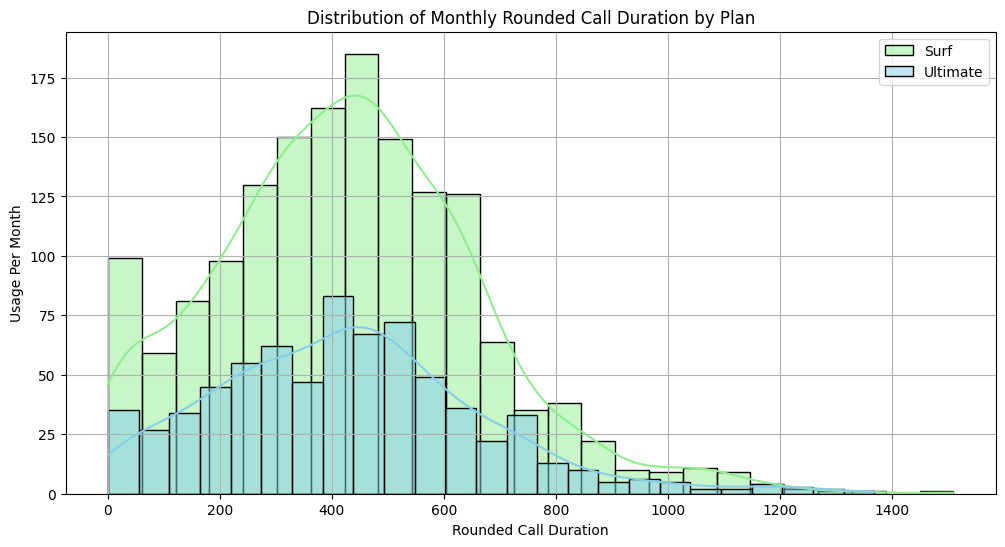

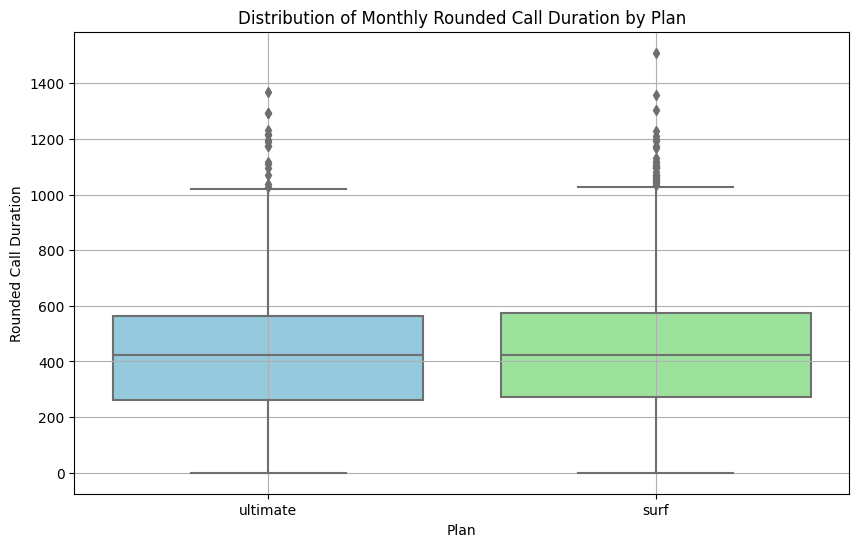

In [40]:
calculate_plan_statistics('rounded_call_duration')

### Surf and Ultimate Monthly call Duration

Based on the box plots, histograms, and calculations of the standard deviation, variance, and mean for both plans, the users behave pretty similarly. Both are right skewed with outlier data at the higher amount of calling minutes per month. Additionally, both have a considerable amount of users that didn't make many calls at all.

## Monthly Message Amounts by Plan

Surf Plan - message_count:
Mean: 31.15956770502225
Variance: 1126.7245219504066
Standard Deviation: 33.566717473569064
Ultimate Plan - message_count:
Mean: 37.55138888888889
Variance: 1208.756743548138
Standard Deviation: 34.76717911404574


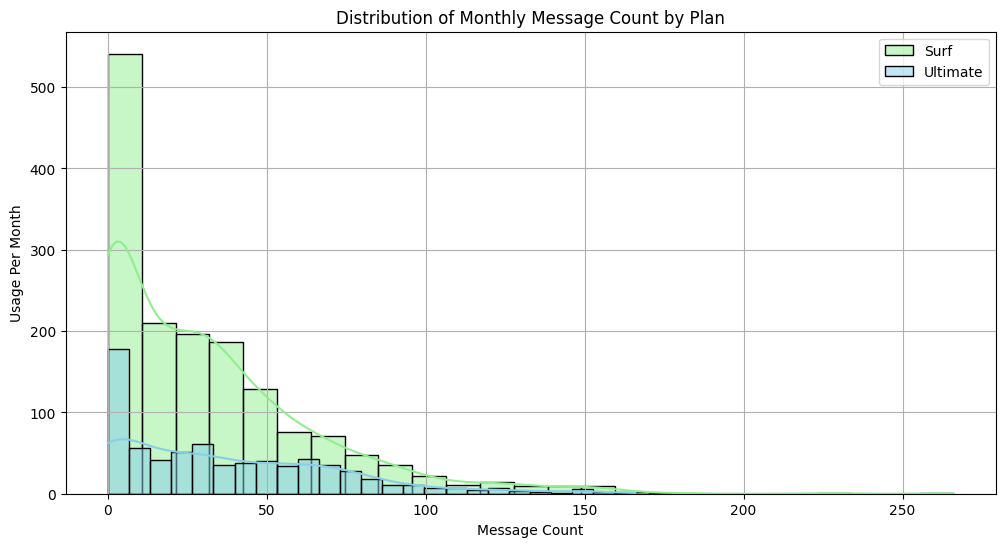

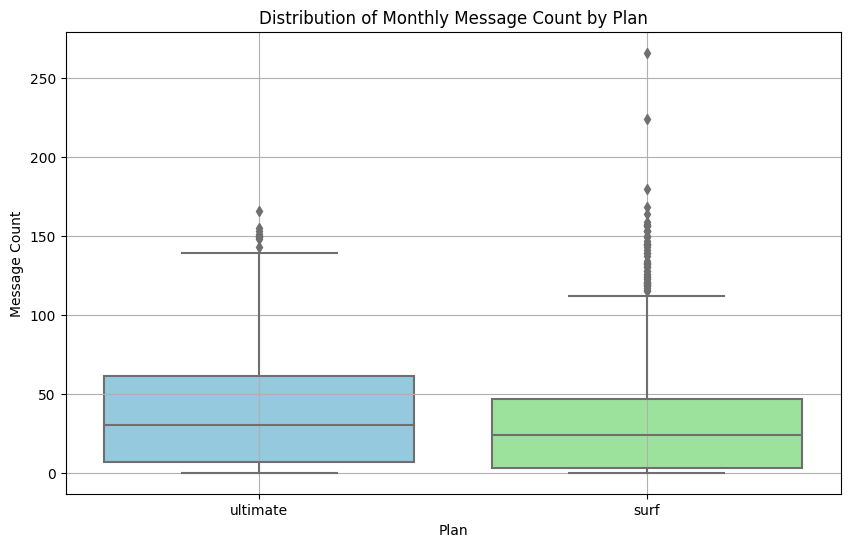

In [41]:
calculate_plan_statistics('message_count')

### Monthly Messages per Plan

Based on the box plots, histograms, and calculations of the standard deviation, variance, and mean for both plans, the users behave pretty similarly. Both are right skewed with outlier data at the higher end of messages per month. Additionally, both have a considerable amount of users that didn't send many messages at all.

However, the data shows that the surf users send less messages on average and have more high outliers.

## Internet Usage 

Surf Plan - mb_per_month:
Mean: 16558.77685950413
Variance: 64216445.45971862
Standard Deviation: 8013.516422876952
Ultimate Plan - mb_per_month:
Mean: 17215.202777777777
Variance: 61652123.608337194
Standard Deviation: 7851.886627323219


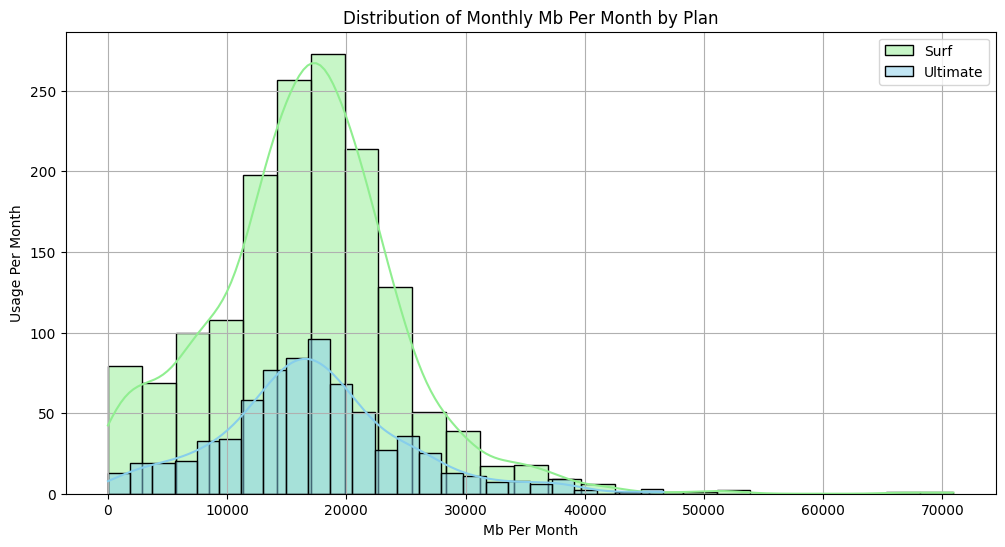

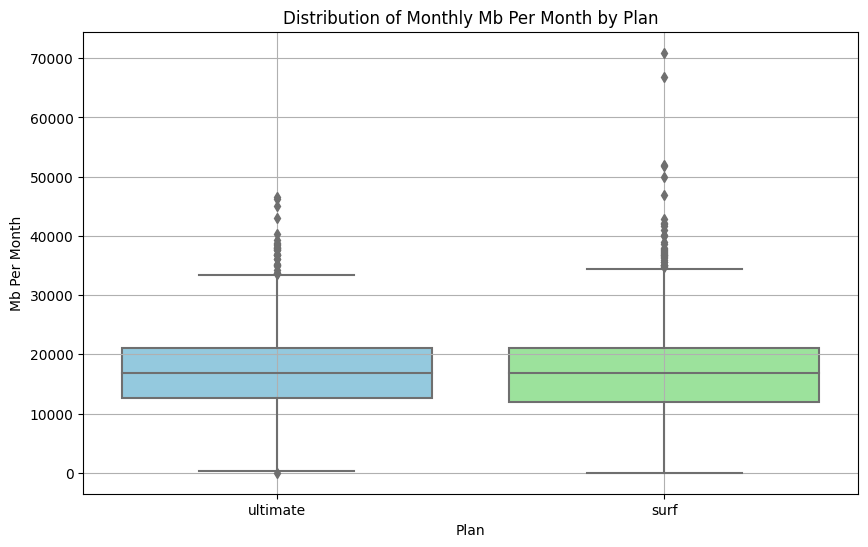

In [42]:
calculate_plan_statistics('mb_per_month')

### Monthly Internet Usage by Plan

Based on the box plots, histograms, and calculations of the standard deviation, variance, and mean for both plans, the users behave pretty similarly. Both are slightly right skewed but closer to a normal bell curve with outlier data at the higher amount of internet usage per month. There is a smaller amount of users that didn't use any internet at all.

## Revenue by Plan

In [43]:
surf_monthly = data_per_month[data_per_month['plan'] == 'surf']
ultimate_monthly = data_per_month[data_per_month['plan'] == 'ultimate']

In [44]:
# Group by month and sum revenue counts
ult_revenue = ultimate_monthly.groupby(['month'])['monthly_revenue'].sum().reset_index()

# Mapping of month names to month numbers
month_mapping = {
    1: 'January',
    2: 'February',
    3: 'March',
    4: 'April',
    5: 'May',
    6: 'June',
    7: 'July',
    8: 'August',
    9: 'September',
    10: 'October',
    11: 'November',
    12: 'December'
}

# Add the month_number column using the mapping
ult_revenue['month_number'] = ult_revenue['month'].map(month_mapping)

# Sort by month_number
ult_revenue = ult_revenue.sort_values(by='month_number').reset_index(drop=True)
display(ult_revenue)

,month,monthly_revenue,month_number
0,4.0,1533.0,April
1,8.0,5173.0,August
2,12.0,11067.0,December
3,2.0,490.0,February
4,1.0,280.0,January
5,7.0,4242.0,July
6,6.0,3367.0,June
7,3.0,896.0,March
8,5.0,2051.0,May
9,11.0,9107.0,November


In [45]:
# Group by month and sum revenue counts
surf_revenue = surf_monthly.groupby(['month'])['monthly_revenue'].sum().reset_index()

# Mapping of month names to month numbers
month_mapping = {
    1: 'January',
    2: 'February',
    3: 'March',
    4: 'April',
    5: 'May',
    6: 'June',
    7: 'July',
    8: 'August',
    9: 'September',
    10: 'October',
    11: 'November',
    12: 'December'
}

# Add the month_number column using the mapping
surf_revenue['month_number'] = surf_revenue['month'].map(month_mapping)

# Sort by month_number
surf_revenue = surf_revenue.sort_values(by='month_number').reset_index(drop=True)
display(surf_revenue)

,month,monthly_revenue,month_number
0,4.0,2035.53,April
1,8.0,10356.85,August
2,12.0,22437.14,December
3,2.0,309.57,February
4,1.0,40.00,January
5,7.0,7583.56,July
6,6.0,4779.80,June
7,3.0,1056.65,March
8,5.0,3667.37,May
9,11.0,16415.21,November


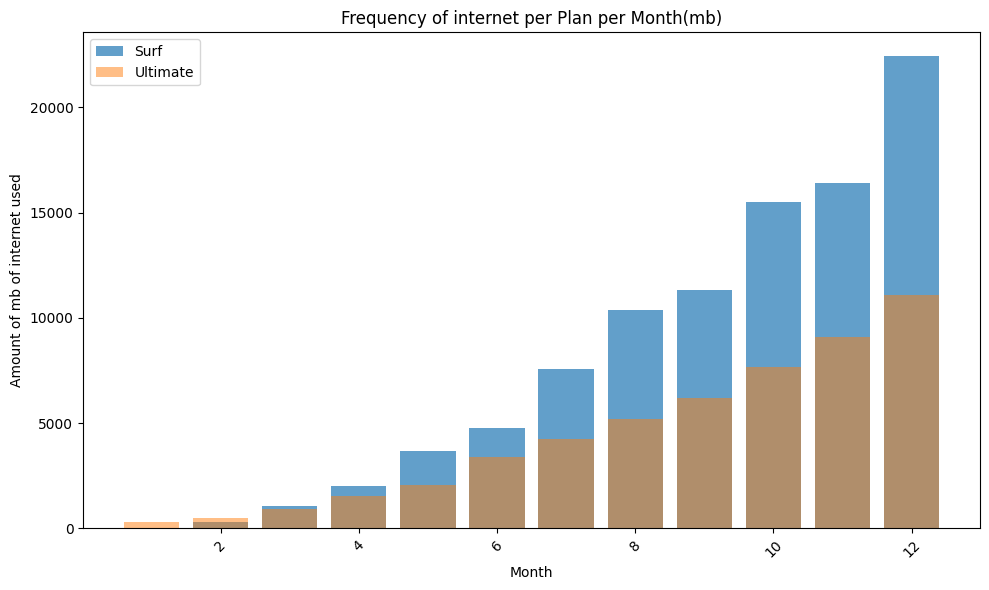

In [46]:
# Plotting the bar plot
plt.figure(figsize=(10, 6))
plt.bar(surf_revenue['month'], surf_revenue['monthly_revenue'], label='Surf', alpha=0.7)
plt.bar(ult_revenue['month'], ult_revenue['monthly_revenue'], label='Ultimate', alpha=0.5)

plt.xlabel('Month')
plt.ylabel('Amount of mb of internet used')
plt.title('Frequency of internet per Plan per Month(mb)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [47]:
# Compare the amount of messages by users per plan

# Calculate the mean and the variance of the monthly call duration
ultimate_mean_rev = ult_revenue['monthly_revenue'].mean()
ultimate_var_rev = ult_revenue['monthly_revenue'].var()

surf_mean_rev = surf_revenue['monthly_revenue'].mean()
surf_var_rev = surf_revenue['monthly_revenue'].var()

print("Ultimate Plan - Mean Revenue:", ultimate_mean_rev)
print("Ultimate Plan - Variance of Revenue:", ultimate_var_rev)

print("\nSurf Plan - Mean Revenue:", surf_mean_rev)
print("Surf Plan - Variance of Revenue:", surf_var_rev)

Ultimate Plan - Mean Revenue: 4338.833333333333
Ultimate Plan - Variance of Revenue: 12764516.333333332

Surf Plan - Mean Revenue: 7957.598333333335
Surf Plan - Variance of Revenue: 53420670.28970612


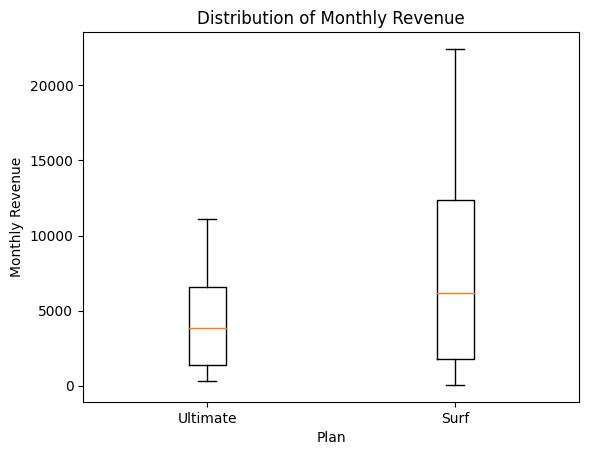

In [48]:
# Plot a boxplot to visualize the distribution of the monthly call duration

fig, ax = plt.subplots()

# Plot boxplot for ultimate plan
ax.boxplot(ult_revenue['monthly_revenue'], positions=[1], labels=['Ultimate'])

# Plot boxplot for surf plan
ax.boxplot(surf_revenue['monthly_revenue'], positions=[2], labels=['Surf'])

# Set labels and title
ax.set_xlabel('Plan')
ax.set_ylabel('Monthly Revenue')
ax.set_title('Distribution of Monthly Revenue')

# Show plot
plt.show()

Again, the Surf plan has a larger right skew than the ultimate plan.

## Test statistical hypotheses

### Surf vs Ultimate Users


***H0:**** There is no difference in the revenues of the ultimate plan users and the surf plan users.

***H1:*** There is a differenece in revenue between the two plan users.

An independent t-test will be conducted on the the two data sets because the simple question of are they the same or not is all we desire.


In [49]:
# Test the hypotheses
results = st.ttest_ind(ult_revenue['monthly_revenue'], surf_revenue['monthly_revenue'])

alpha =0.05
print('p-value: ', results.pvalue)


if results.pvalue < alpha:
    print("We reject the null hypothesis")
else:
    print("We can't reject the null hypothesis")


p-value:  0.13760614119010917
We can't reject the null hypothesis


### NY-NJ Users
Tested the hypothesis that the average revenue from users in the NY-NJ area is different from that of the users from the other regions.

In [50]:
display(surf_monthly.head())
display(ultimate_monthly.head())

,user_id,month,plan,city,num_calls,rounded_call_duration,message_count,mb_per_month,gb_month,monthly_revenue
1,1001,8.0,surf,"Seattle-Tacoma-Bellevue, WA MSA",27.0,182.0,30.0,6920.0,7.0,20.00
2,1001,9.0,surf,"Seattle-Tacoma-Bellevue, WA MSA",49.0,315.0,44.0,13315.0,14.0,20.00
3,1001,10.0,surf,"Seattle-Tacoma-Bellevue, WA MSA",65.0,393.0,53.0,22331.0,22.0,90.09
4,1001,11.0,surf,"Seattle-Tacoma-Bellevue, WA MSA",64.0,426.0,36.0,18505.0,19.0,60.00
5,1001,12.0,surf,"Seattle-Tacoma-Bellevue, WA MSA",56.0,412.0,44.0,19370.0,19.0,60.00


,user_id,month,plan,city,num_calls,rounded_call_duration,message_count,mb_per_month,gb_month,monthly_revenue
0,1000,12.0,ultimate,"Atlanta-Sandy Springs-Roswell, GA MSA",16.0,124.0,11.0,1902.0,2.0,70.0
19,1006,11.0,ultimate,"San Francisco-Oakland-Berkeley, CA MSA",2.0,10.0,15.0,2069.0,3.0,70.0
20,1006,12.0,ultimate,"San Francisco-Oakland-Berkeley, CA MSA",9.0,59.0,139.0,32119.0,32.0,84.0
26,1008,10.0,ultimate,"Orlando-Kissimmee-Sanford, FL MSA",71.0,476.0,21.0,17107.0,17.0,70.0
27,1008,11.0,ultimate,"Orlando-Kissimmee-Sanford, FL MSA",63.0,446.0,37.0,23677.0,24.0,70.0


In [51]:
surf_rev_njny = surf_monthly[['user_id', 'month', 'city', 'monthly_revenue']]
surf_rev_rest = surf_monthly[['user_id', 'month', 'city', 'monthly_revenue']]

# Select rows with 'NJ' or 'NY' in the city column
surf_rev_njny = surf_rev_njny[surf_rev_njny['city'].str.contains('NJ|NY')]

# Select rows with cities other than 'NJ' and 'NY'
surf_rev_rest = surf_rev_rest[~surf_rev_rest['city'].str.contains('NJ|NY')]

display(surf_rev_njny['city'].unique())

array(['New York-Newark-Jersey City, NY-NJ-PA MSA',
       'Philadelphia-Camden-Wilmington, PA-NJ-DE-MD MSA',
       'Buffalo-Cheektowaga, NY MSA', 'Albany-Schenectady-Troy, NY MSA',
       'Rochester, NY MSA'], dtype=object)

In [52]:
ult_rev_njny = ultimate_monthly[['user_id', 'month', 'city', 'monthly_revenue']]
ult_rev_rest = ultimate_monthly[['user_id', 'month', 'city', 'monthly_revenue']]

# Select rows with 'NJ' or 'NY' in the city column
ult_rev_njny = ult_rev_njny[ult_rev_njny['city'].str.contains('NJ|NY')]

# Select rows with cities other than 'NJ' and 'NY'
ult_rev_rest = ult_rev_rest[~ult_rev_rest['city'].str.contains('NJ|NY')]

THe NJ-NY data has 'Philadelphia-Camden-Wilmington, PA-NJ-DE-MD MSA' as one of the cities. Which will be included in the NJ-NY data because it has NJ in it's description.

The surf and ultimate plan were seperately studied.

***H0:*** There is no difference in the revenues of the ultimate plan users in NJ-NY area compared to elsewhere.

***H1:*** There is a differenece in revenue between NJ-NY users and elsewhere.

An independent t-test will be conducted on the the two data sets because the simple question of are they the same or not is all we desire.


In [53]:
# Test the hypotheses
results = st.ttest_ind(ult_rev_njny['monthly_revenue'], ult_rev_rest['monthly_revenue'])

alpha =0.05
print('p-value: ', results.pvalue)


if results.pvalue < alpha:
    print("We reject the null hypothesis")
else:
    print("We can't reject the null hypothesis")


p-value:  6.735356776146324e-10
We reject the null hypothesis



***H0:*** There is no difference in the revenues of the surf plan users in NJ-NY area compared to elsewhere.

***H1:*** There is a differenece in revenue between NJ-NY users and elsewhere.

An independent t-test will be conducted on the the two data sets because the simple question of are they the same or not is all we desire.

In [54]:
# Test the hypotheses
results = st.ttest_ind(surf_rev_njny['monthly_revenue'], surf_rev_rest['monthly_revenue'])

alpha =0.05
print('p-value: ', results.pvalue)


if results.pvalue < alpha:
    print("We reject the null hypothesis")
else:
    print("We can't reject the null hypothesis")


p-value:  0.12835184685674497
We can't reject the null hypothesis


Based on the t-test, we can reject that the revenue is the same for the ultimate data. There is a different amount of revenue form the people who live in NY or NJ than the rest of the users. However, the opposite can be said of the users in the surf plan. The revenue cannot be said to be different between the people who live in NY and NJ and the rest of the users.

## Conclusion

Based on the analysis, the following conclusions and recommendations can be made:

Revenue Comparison:

- The t-test results indicate that the overall revenue from both plans is statistically similar. Conclusively its no possible to say that one plan generates more revenue than the other across the entire population.
- However, in specific regions like NY-NJ, there is a noticeable difference in revenue, with one plan potentially outperforming the other.


User Behavior:

- Users on the Surf plan tend to use fewer messages and data compared to Ultimate plan users.
- The Ultimate plan users generally have higher call durations, message counts, and data usage, which might suggest a preference for heavy usage customers.

Plan Recommendations:

- For users in regions like NY-NJ, consider promoting the plan that generates higher revenue in these areas.
- Given the heavy usage patterns, the Ultimate plan might be more suitable for users with high data and call needs.
- For lighter users or those more cost-sensitive, the Surf plan could be a better fit.
